# Práctica 4 - Recurrent Neural Networks y Transformers

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

In [1]:
# EJECUTAR ESTA CELDA SOLO EN GOOGLE COLAB
# PRIMERO HAY QUE SUBIR UN ZIP CON LOS ARCHIVOS DE TRAIN Y TEST
# AQUI SE DESCOMPRIME
import zipfile
import os

print("Descomprimiendo midi.zip")
with zipfile.ZipFile('midi.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
print("Carpeta descomprimida")

print("\nArchivos MIDI en train/:", len(os.listdir('midi/train')))
print("Archivos MIDI en test/:", len(os.listdir('midi/test')))

Descomprimiendo midi.zip
Carpeta descomprimida

Archivos MIDI en train/: 4905
Archivos MIDI en test/: 373


In [2]:
# EJECUTAR ESTO SOLO EN GOOGLE COLAB
!pip install miditok numpy tensorflow keras matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 93.7 MB/s eta 0:00:00


Primero importamos todas las librerías que vamos a necesitar:

In [3]:
import os
import numpy as np
from miditok import REMI, TokenizerConfig, TokSequence
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [4]:
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 1. Carga y preprocesado del dataset

Creamos el tokenizador. Este transforma la información de la música del fichero MIDI en una secuencia de tokens dicretos, que es el formato válido de entrada de los modelos.
Para esto, seguimos el ejemplo del enunciado de la práctica.

In [5]:
# Configurar el tokenizador REMI
config = TokenizerConfig()
tokenizer = REMI(config)

Definimos las rutas de los conjuntos de entrenamiento y test y obtenemos la lista de ficheros MIDI de cada uno. De esta manera podemos entrenar los modelos con un conjunto de datos y luego evaluarlos sobre datos no vistos.

In [6]:
# Definir las rutas de los datos
MIDI_DIR = "midi"
TRAIN_DIR = os.path.join(MIDI_DIR, "train")
TEST_DIR = os.path.join(MIDI_DIR, "test")

# Obtener lista de archivos midi
train_files = sorted([os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.mid')])
test_files = sorted([os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.mid')])

Esta función toma los tokens de un archivo MIDI y los organiza en ventanas de 51 tokens:
- **Si el archivo tiene menos de 51 tokens**: añadimos el token EOS para marcar el final y rellenamos con PAD.
- **Si el archivo tiene más de 51 tokens**: creamos ventanas deslizantes. La ventana se ma moviendo token a token: primero cogemos los tokens del 1 al 51, luego movemos la ventana una posición y cogemos del 2 al 52, después del 3 al 53, y así sucesivamente hasta llegar al final.

Esto permite adaptar cualquier canción al formato requerido por los modelos.

In [7]:
def create_sequences(token_ids, tokenizer, seq_length=51):
    """
    Crea secuencias de longitud fija a partir de los tokens de un archivo midi.
    - Si hay menos de 51 tokens: rellena con EOS + PAD
    - Si hay más de 51 tokens: usa ventanas deslizantes
    """
    sequences = [] # Lista para guardar todas las secuencias

    # Obtener los ids de los tokens especiales
    # Los vamos a usar cuando el midi no llegue a 51 tokens
    eos_token = tokenizer['EOS_None'] # marca el final de una secuencia
    pad_token = tokenizer['PAD_None'] # token de relleno

    # si la canción tiene menos de 51 tokens rellenar
    if len(token_ids) < seq_length:
        # Añadir el token EOS al final para marcar donde termina
        sequence = token_ids + [eos_token]
        # Calcular cuántos tokens PAD necesitamos para llegar a 51
        padding_needed = seq_length - len(sequence)
        # Añadir ese numero de pads
        sequence = sequence + [pad_token] * padding_needed
        sequences.append(sequence)

    # Si tiene 51 o mas tokens usar ventanas deslizantes
    else:
        # extrae 51 tokens desde la primera posición
        # pasa a la segunda y extrae 51 desde esa posición, etc, etc
        for i in range(len(token_ids) - seq_length + 1):
            sequence = token_ids[i:i + seq_length]
            sequences.append(sequence)

    return sequences

Esta función procesa todos los archivos MIDI de una carpeta (train o test). Primero lee cada archivo MIDI, lo tokeniza y extrae solo el primer canal. Luego crea las ventanas de 51 tokens para cada archivo y guarda todas las secuencias juntas.

In [8]:
def process_dataset(file_list, tokenizer, seq_length=51):
    """
    Procesa todos los archivos MIDI y crea las secuencias
    """
    all_sequences = [] # Lista para guardar secuencias de todos los archivos

    for file_path in file_list:
        # Tokenizar el archivo
        tokens = tokenizer(file_path)
        # Obtener los ids del primer canal (índice 0)
        token_ids = tokens[0].ids
        # Crear secuencias de longitud fija con la funcion de la celda de arriba
        sequences = create_sequences(token_ids, tokenizer, seq_length)
        # Añadir todas las secuencias de este archivo a la lista total
        all_sequences.extend(sequences)
    # Convertir a numpy
    return np.array(all_sequences)

Esta función separa cada ventana de 51 tokens en entrada y salida, ya que vamos a hacer redes que predigan el siguiente token:
- **Entrada (X)**: los primeros 50 tokens (posiciones 0 a 49). Lo que la red recibe como contexto
- **Etiqueta (y)**: los últimos 50 tokens (posiciones 1 a 50). Lo que la red debe predecir

Con esto, el modelo aprende a predecir el siguiente token en cada posición sin utilizar información futura.


In [9]:
def prepare_data_for_training(sequences):
    """
    Para una ventana de 51 tokens:
    - Entrada: los primeros 50 tokens
    - Etiqueta: los últimos 50 tokens
    """
    # numero de secuencias, longitud
    X = sequences[:, :50] # Primeros 50 tokens (del 0 al 49)
    y = sequences[:, 1:] # Últimos 50 tokens (del token 1 al 50)

    return X, y

Ahora aplicamos las funciones anteriores para generar los conjuntos finales de entrenamiento y test. También comprobamos el número total de ventanas generadas y las dimensiones X e y.

In [10]:
# Procesar el conjunto de entrenamiento
# tokenizar cada archivo y crea ventanas de 51 tokens
train_sequences = process_dataset(train_files, tokenizer, seq_length=51)
# Separar en entrada y salida con ventanas
X_train, y_train = prepare_data_for_training(train_sequences)

print(f"Secuencias de entrenamiento creadas: {len(train_sequences)}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

# Procesar el conjunto de test
# tokenizar cada archivo y crea ventanas de 51 tokens
test_sequences = process_dataset(test_files, tokenizer, seq_length=51)
# Separar en entrada y salida con ventanas
X_test, y_test = prepare_data_for_training(test_sequences)

print(f"Secuencias de test creadas: {len(test_sequences)}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Secuencias de entrenamiento creadas: 2894912
Forma de X_train: (2894912, 50)
Forma de y_train: (2894912, 50)
Secuencias de test creadas: 139315
Forma de X_test: (139315, 50)
Forma de y_test: (139315, 50)


### 2. Red RNN simple

Antes de crear la red, necesitamos saber cuántos tokens diferentes existen en nuestro vocabulario para saber cuántos tokens diferentes puede predecir.

Este valor lo usamos para definir la dimensión de salida de las redes neuronales.

In [11]:
# Obtener el tamaño del vocabulario (cuántos tokens diferentes hay)
vocab_size = len(tokenizer.vocab)
print(f"Tamaño del vocabulario: {vocab_size}")

Tamaño del vocabulario: 284


In [12]:
# Dibuja las curvas de loss y accuracy durante el entrenamiento
def plot(history):
    accuracy = history.history["accuracy"]
    loss = history.history["loss"]

    epochs = range(1, len(accuracy) + 1)

    # dos gráficas una al lado de la otra
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.set_title("Training accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.set_title("Training loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Definimos los hiperparámetros del modelo, junto con la función de loss y el optimizador:

In [13]:
# Hiperparámetros
EMBEDDING_DIM = 64 # Tamaño de la representación de cada token
RNN_UNITS = 128 # Número de unidades en la capa recurrente
BATCH_SIZE = 4096 # Cuántas secuencias procesamos a la vez
EPOCHS = 10 # Cuántas veces pasamos por todos los datos
optimizer_rnn_simple = tf.keras.optimizers.AdamW(learning_rate=3e-4) # método para ajustar los pesos
loss_rnn_simple = tf.keras.losses.SparseCategoricalCrossentropy() # funcion de loss

Hemos elegido estos hiperparámetros (embedding de 64 dimensiones, 128 unidades en la capa LSTM, batch de 4096, 10 epochs, learning rate 3e-4) para tener equilibrio entre un buen aprendizaje y ejecuciones en tiempos razonables.

AdamW es una variante de Adam que ajusta mejor los pesos. Utilizamos un learning rate de 3e-4.

Usamos SparseCategoricalCrossentropy ya que este se trata de un problema de clasificación multiclase clase (hay que predecir qué token viene después). En concreto, Sparse al tratarse de un vocabulario con 284 tokens donde las etiquetas son índices enteros en lugar de vectores one-hot.


La RNN simple incluye:
- Una capa Embedding que convierte cada token en un vector longitud 64. Los tokens relacionados quedan cerca en el espacio.
- Una capa recurrente LSTM que procesa la secuencia manteniendo memoria de lo que ha visto anteriormente. Usamos `return_sequences=True` para obtener una predicción por cada token de la secuencia.
- Una capa Dense que proyecta cada salida del LSTM (128 dimensiones) al tamaño del vocabulario (284 dimensiones). Softmax convierte los resultados a probabilidades que sumen 1.

In [14]:
def crear_rnn_simple(vocab_size, embedding_dim, rnn_units, seq_length=50):
    # entrada
    # recibe secuencias de tokens de longitud 50
    inputs = layers.Input(shape=(seq_length,), name='input_layer')

    # Embedding
    # convierte cada token (número) en un vector
    x = layers.Embedding(input_dim=vocab_size, # tamaño del vocabulario
                        output_dim=embedding_dim, # tamaño del vector de cada palabra
                        name='embedding')(inputs)

    # capa LSTM
    x = layers.LSTM(units=rnn_units, return_sequences=True, # salida para cada token
                    name='lstm')(x)

    # capa de salida
    outputs = layers.Dense(units=vocab_size, # una salida por cada palabra del vocabulario
                           activation='softmax', # convierte a probabilidades
                           name='output')(x)

    # Crear modelo
    model = keras.Model(inputs, outputs, name='rnn_simple')
    return model

# Crear
model_simple = crear_rnn_simple(vocab_size, EMBEDDING_DIM, RNN_UNITS, seq_length=50)

# Compilar
model_simple.compile(optimizer=optimizer_rnn_simple, loss=loss_rnn_simple, metrics=['accuracy'])

model_simple.summary()

Model: "rnn_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 50, 284)        │        36,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,628 (600.11 KB)

 Trainable params: 153,628 (600.11 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Entrenar el modelo
history = model_simple.fit(
    X_train, y_train, # Datos de entrenamiento
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 112s 151ms/step - accuracy: 0.2710 - loss: 3.5524
Epoch 2/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 108s 153ms/step - accuracy: 0.4213 - loss: 2.1897
Epoch 3/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.4625 - loss: 1.8920
Epoch 4/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.5066 - loss: 1.7017
Epoch 5/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 108s 152ms/step - accuracy: 0.5353 - loss: 1.5900
Epoch 6/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.5526 - loss: 1.5243
Epoch 7/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.5642 - loss: 1.4822
Epoch 8/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 151ms/step - accuracy: 0.5738 - loss: 1.4498
Epoch 9/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.5829 - loss: 1.4215
Epoch 10/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.5907 - loss: 1.3958


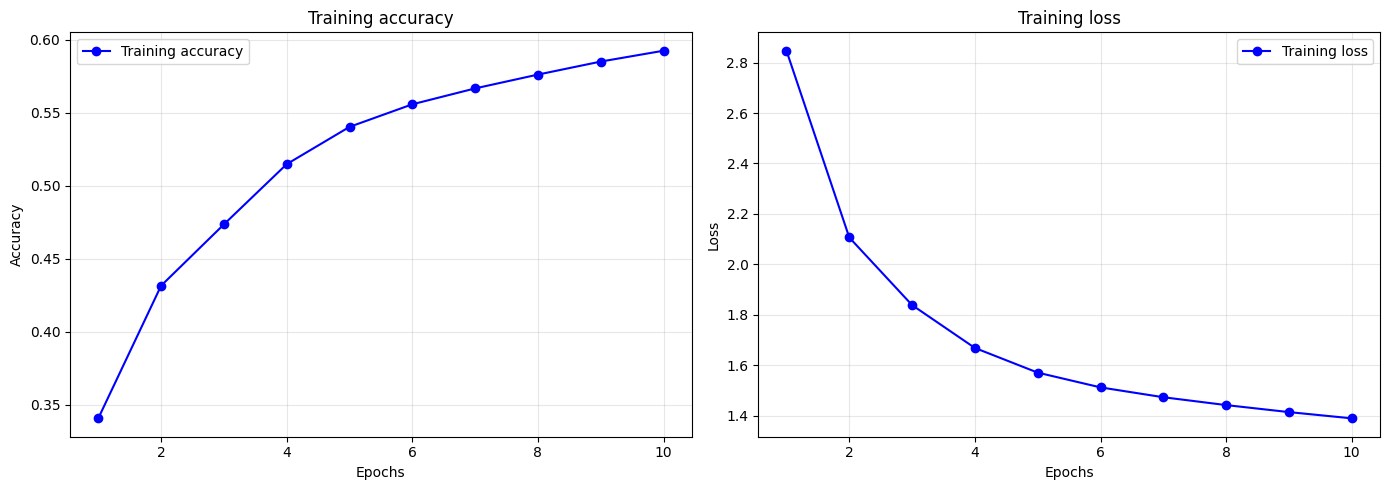

In [16]:
plot(history) # dibujar las curvas de entrenamiento

Podemos observar que el modelo evoluciona de forma estable (no vemos ninguna oscilación)durante el entrenamiento. En los primeros epochs el accuracy aumenta considerablemente, pasando de 0.2710 en el primer epoch a 0.4213 en el segundo, mientras que el loss desciende de 3.5524 en el primer epoch a 2.1897 en el segundo. Aquí la red está aprendiendo los patrones básicos (como transiciones que se repiten mucho entre tokens).

En los epochs intermedios, la mejora es más progresiva: el accuracy aumenta de forma más gradual y loss sigue descenciendo. Esto sugiere que el modelo empieza a aprender patrones más complejos.

En los epochs finales, las métricas se estabilizan. El accuracy llega a 0.5907 en el último epoch y el loss se estabiliza entorno a 1.40. El modelo está prediciendo correctamente el siguiente token 6 de cada 10 veces, algo aceptable para este vocabulario.

### 3. Red RNN anidada

Definimos los mismos hiperparámetros que para la red anterior:

In [17]:
# Hiperparámetros para la RNN anidada
EMBEDDING_DIM_ANIDADA = 64 # Mismo que antes
RNN_UNITS_L1 = 128 # Unidades en la primera capa LSTM
RNN_UNITS_L2 = 128 # Unidades en la segunda capa LSTM
BATCH_SIZE_ANIDADA = 4096 # Mismo batch size
EPOCHS_ANIDADA = 10 # Mismo número de epochs
optimizer_rnn_anidada = tf.keras.optimizers.AdamW(learning_rate=3e-4)
loss_rnn_anidada = tf.keras.losses.SparseCategoricalCrossentropy()

Para la RNN anidada, utilizamos 2 capas LSTM en lugar de una para aumentar la capacidad del modelo. Esto debería de capturar dependencias más complejas que el modelo del apartado anterior y mantener información importante durante más pasos temporales.

In [18]:
def crear_rnn_anidada(vocab_size, embedding_dim, rnn_units_l1, rnn_units_l2, seq_length=50):
    """
    Crea una RNN anidada con:
    - Capa Embedding: convierte tokens en vectores
    - Primera capa LSTM: procesa la secuencia
    - Segunda capa LSTM: procesa la salida de la primera
    - Capa Dense: predice el siguiente token
    """
    # Definir entrada
    inputs = layers.Input(shape=(seq_length,), name='input_layer')

    # Capa embedding: convierte cada token en un vector
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='embedding')(inputs)

    # Primera capa LSTM
    # return_sequences=True para pasar toda la secuencia a la siguiente LSTM
    x = layers.LSTM(units=rnn_units_l1, return_sequences=True, name='lstm_1')(x)

    # Segunda capa LSTM (procesa la salida de la primera)
    # También con return_sequences=True porque queremos predecir en cada paso
    x = layers.LSTM(units=rnn_units_l2, return_sequences=True,  # Para predecir token por token
                    name='lstm_2')(x)

    # Capa de salida que convierte en probabilidades para cada token
    outputs = layers.Dense(units=vocab_size, activation='softmax', name='output')(x)

    # Crear modelo
    model = keras.Model(inputs, outputs, name='rnn_anidada')
    return model

# Crear el modelo anidado
model_anidada = crear_rnn_anidada(vocab_size, EMBEDDING_DIM_ANIDADA, RNN_UNITS_L1, RNN_UNITS_L2, seq_length=50)

# Compilar
model_anidada.compile(optimizer=optimizer_rnn_anidada, loss=loss_rnn_anidada, metrics=['accuracy'])

model_anidada.summary()

Model: "rnn_anidada"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 50, 284)        │        36,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,212 (1.09 MB)

 Trainable params: 285,212 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Entrenar el modelo anidado
history_anidada = model_anidada.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE_ANIDADA,
    epochs=EPOCHS_ANIDADA,
    verbose=1)

Epoch 1/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 160s 223ms/step - accuracy: 0.2483 - loss: 3.8009
Epoch 2/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.4214 - loss: 2.1919
Epoch 3/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.4771 - loss: 1.8347
Epoch 4/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.5167 - loss: 1.6700
Epoch 5/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.5449 - loss: 1.5685
Epoch 6/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 202s 223ms/step - accuracy: 0.5643 - loss: 1.5010
Epoch 7/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.5778 - loss: 1.4498
Epoch 8/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.5883 - loss: 1.4106
Epoch 9/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.5969 - loss: 1.3793
Epoch 10/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.6041 - loss: 1.3537


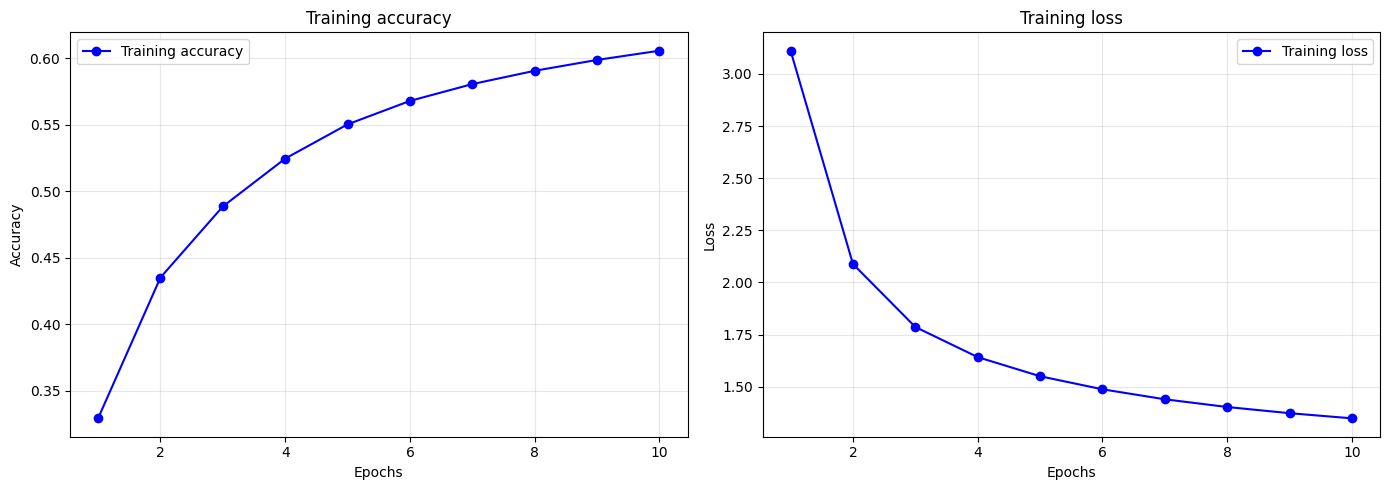

In [20]:
plot(history_anidada)

La RNN anidada muestra un comportamiento muy parecido a la anterior pero con mejoras: en los primeros epochs el accuracy aumenta de forma notable, pasando de 0.2483 en el primer epoch a 0.4214 en el segundo, mientras que el loss desciende de manera pronunciada de 3.8009 a 2.1919. Cabe mencionar que este aprendizaje es más lento que el del modelo simple.También arranca con un accuracy ligeramente inferior y un loss un poco más alto.

En los epochs intermedios la mejora continúa de manera más gradual, alcanzando valores de accuracy superiores a los de la RNN simple. Añadir una segunda capa LSTM permite capturar patrones temporales más complejos y relaciones entre tokens que están más separados en el tiempo.

El accuracy alcanza un valor de 0.6041 en el último epoch (mejor que la RNN simple) y tampoco ha mostrado inestabilidad.

In [21]:
print("EVALUACIÓN EN CONJUNTO DE TEST")

test_loss, test_accuracy = model_anidada.evaluate(X_test, y_test,
    batch_size=BATCH_SIZE_ANIDADA, verbose=1)

print("\nRESULTADOS EN TEST:")
print(f"\tLoss: {test_loss:.4f}")
print(f"\tAccuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

EVALUACIÓN EN CONJUNTO DE TEST
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5664 - loss: 1.5141

RESULTADOS EN TEST:
	Loss: 1.4592
	Accuracy: 0.5803 (58.03%)


Evaluamos el modelo sobre el conjunto de test para poder medir su capacidad de generalización sobre datos no vistos durante el entrenamiento.

En este conjunto se obtiene un accuracy del 58.03% y un loss de 1.4592. Estos resultados son un poco inferiores a los obtenidos durante el entrenamiento, lo cual es esperable. Esto sugiere que el modelo no presenta sobreajuste.

La poca diferencia entre los resultados de entrenamiento y test indica que la RNN anidada tiene una buena capacidad de generalización. Sin embargo, sigue teniendo dificultades para hacer predicciones correctas.

## 4. Transformer

Para este apartado hemos seguido la estructura utilizada en el laboratorio 12.

A diferencia de las RNN, el transformer procesa todos los tokens al mismo tiempo mediante mecanismos de atención, eliminando la limitación secuencial de los modelos recurrentes.

La arquitectura se construye mediante varias clases:
- `Head`: implementa una única cabeza de self-attention que calcula las relaciones entre tokens utilizando keys, queries y values, aplicando una máscara causal (para que la predicción del token una posición solo use información de posiciones anteriores).
- `MultiHeadAttention`: ejecuta varias cabezas de atención en paralelo (4 en nuestro caso) y combina sus salidas, aumentando la capacidad del modelo para capturar diferentes tipos de relaciones.
- `FeedForward`: red neuronal aplicada a cada posición de la secuencia.
- `GPTBlock`: bloque del Transformer que combina atención multi-cabeza y red feed-forward. Usa conexiones residuales (suma la entrada a la salida) y normalización.
- `GPTLanguageModel`: modelo completo que integra los embeddings de tokens y posiciones, los bloques Transformer (2 en nuestro caso)y la capa de salida.


Esta clase implementa una cabeza de self-attention. Para cada token de la secuencia se calculan tres representaciones: key, query y value.

El producto escalar entre queries y keys permite medir la relación entre tokens. Se aplica una máscara causal para evitar que el modelo utilice información futura, asegurando que la predicción del token actual solo depende de tokens anteriores.

Esto permite capturar dependencias entre tokens independientemente de su distancia temporal.


In [22]:
class Head(tf.keras.layers.Layer):
    """ Implementa una única cabeza de self-attention."""

    def __init__(self, head_size, block_size, dropout):
        super(Head, self).__init__()
        # Capas lineales de tamaño de salida head_size
        self.key = tf.keras.layers.Dense(head_size, use_bias=False)
        self.query = tf.keras.layers.Dense(head_size, use_bias=False)
        self.value = tf.keras.layers.Dense(head_size, use_bias=False)

        # Matriz triangular inferior (causal mask)
        self.tril = tf.linalg.band_part(tf.ones((block_size, block_size)), -1, 0)

        self.dropout = tf.keras.layers.Dropout(dropout) # se suele aplicar justo sobre la matrix previa a aplicar softmax
        self.scale_factor = tf.math.sqrt(tf.cast(head_size, tf.float32))

    def call(self, x, training=False):
        B, T, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2] # Dimensiones: B = batch, T = longitud de secuencia, C = dimensión de embedding

        # Proyección a claves, consultas y valores
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Cálculo de las puntuaciones de atención (producto escalar escalado)
        wei = tf.matmul(q, k, transpose_b=True) / self.scale_factor  # (B, T, T)

        # Aplicación de la máscara causal (no ver tokens futuros)
        mask = self.tril[:T, :T]
        mask = tf.expand_dims(mask, axis=0)
        wei = tf.where(mask == 0, tf.fill(tf.shape(wei), float('-inf')), wei)

        # Normalización con softmax
        wei = tf.nn.softmax(wei, axis=-1)  # (B, T, T)

        # Dropout para regularización
        wei = self.dropout(wei, training=training)

        # Combinación ponderada de los valores
        out = tf.matmul(wei, v)  # (B, T, head_size)

        return out

Esta clase aplica varias cabezas de self-attention en paralelo para generar una multi head attention. Cada cabeza aprende distintos tipos de relaciones entre los tokens.

Las salidas de todas las cabezas se concatenan y se proyectan de nuevo al espacio original, lo que aumenta la capacidad del modelo sin perder información.

Esto permite al modelo atender a diferentes patrones musicales a la vez.


In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """Implementa la atención multi-cabeza"""

    def __init__(self, input_size, num_heads, block_size, dropout, n_embd=None):
        super(MultiHeadAttention, self).__init__()
        if n_embd is None:
            n_embd = input_size
        assert n_embd % num_heads == 0
        head_size = n_embd // num_heads

        # Lista de cabezas de atención
        self.heads = [Head(head_size, block_size, dropout) for _ in range(num_heads)]

        # Proyección final para volver a mapear a input_size
        self.proj = tf.keras.layers.Dense(input_size)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.num_heads = num_heads
        self.head_size = head_size
        self.n_embd = n_embd
        self.input_size = input_size

    def call(self, x, training=False):
        # Aplicar cada cabeza de atención en paralelo
        head_outputs = [head(x, training=training) for head in self.heads]

        # Concatenar las salidas de todas las cabezas
        out = tf.concat(head_outputs, axis=-1)  # (B, T, n_embd)

        # Proyección final al tamaño original del embedding
        out = self.proj(out)

        # Dropout para regularización
        out = self.dropout(out, training=training)

        return out

La red Feed-Forward se aplica de forma independiente a cada posición de la secuencia. Está formada por dos capas densas con una función de activación intermedia.

Su función es transformar la información obtenida tras la atención mediante capas no lineales (aumentando la capacidad de representación).

In [24]:
class FeedForward(tf.keras.layers.Layer):
    """Red Feed-Forward aplicada a cada posición de la secuencia"""

    def __init__(self, input_size, dropout):
        super(FeedForward, self).__init__()
        self.linear_1 = tf.keras.layers.Dense(4 * input_size)
        self.act_1 = tf.keras.layers.ReLU()
        self.linear_2 = tf.keras.layers.Dense(input_size)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        x = self.linear_1(x) # Primera transformación lineal
        x = self.act_1(x)  # Función de activación
        x = self.linear_2(x)  # Segunda transformación lineal
        x = self.dropout(x, training=training) # Dropout para regularización
        return x


Cada bloque Transformer combina un módulo de atención multi-cabza y una red Feed-Forward.

Además se aplica normalización de capa y conexiones residuales, lo que facilita el entrenamiento de modelos profundos y mejora la estabilidad del aprendizaje.

In [25]:
class GPTBlock(tf.keras.layers.Layer):
    """
    Bloque básico del Transformer.

    Combina atención multi-cabeza y una red feed-forward, utilizando conexiones
    residuales y normalización de capa para mejorar la estabilidad del entrenamiento.
    """

    def __init__(self, input_size, num_heads, block_size, dropout, n_embd=None):
        super(GPTBlock, self).__init__()
        # Normalización de capa 1
        self.ln1 = tf.keras.layers.LayerNormalization()
        # Multi-head attention
        self.attn = MultiHeadAttention(input_size, num_heads, block_size, dropout, n_embd)
        # Normalización de capa 2
        self.ln2 = tf.keras.layers.LayerNormalization()
        # Feed-forward
        self.ffn = FeedForward(input_size, dropout)

    def call(self, x, training=False):
        # Atención multicabeza con conexión residual
        x = x + self.attn(self.ln1(x), training=training)
        # Feed forward con conexión residual
        x = x + self.ffn(self.ln2(x), training=training)
        return x

Aquí implementamos el Transformer completo. Usamos embeddings de tokens y embeddings posicionales para introducir información sobre el orden de la secuencia.

Los embeddings se procesan mediante varios bloques Transformer consecutivos y después se proyectan al tamaño del vocabulario para predecir el siguiente token en cada posición.

In [26]:
class GPTLanguageModel(tf.keras.models.Model):
    """Modelo GPT completo"""

    def __init__(self, vocab_size, embedding_size=384, n_blocks=6, num_heads=6, block_size=256, dropout=0.2, n_embd=None):
        super(GPTLanguageModel, self).__init__()

        # Embeddings
        self.vocab_embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.positional_encoding = tf.keras.layers.Embedding(block_size, embedding_size)

        # Bloques transformer
        self.blocks = [GPTBlock(embedding_size, num_heads, block_size, dropout, n_embd) for _ in range(n_blocks)]

        # Capa final
        self.classifier = tf.keras.layers.Dense(vocab_size)

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.block_size = block_size

    def call(self, x, training=False):
        # B, T = K.int_shape(x)
        # SI NO CAMBIABAMOS ESTO SALIA UN ERROR
        # PARECE QUE INT_SHAPE NO FUNCIONA CON TENSORES DINAMICOS
        B = tf.shape(x)[0] # Batch size
        T = tf.shape(x)[1] # Longitud de la secuencia

        # Embeddings de tokens
        token_embs = self.vocab_embedding(x)  # (B, T, embedding_size)

        # Embeddings posicionales
        positions = tf.range(T)
        pos_encoding = self.positional_encoding(positions)  # (T, embedding_size)

        # Suma de embeddings
        embs = token_embs + pos_encoding  # (B, T, embedding_size)

        # Pasar por todos los bloques
        for block in self.blocks:
            embs = block(embs, training=training)

        # Clasificación
        y = self.classifier(embs)  # (B, T, vocab_size)

        return y

Los hiperparámetros comunes con los otros modelos se mantienen igual, con la siguiente excepción: en `SparseCategoricalCrossentropy` especificamos `from_logits=True` (como se hace en el laboratorio 12) para que loss utilice directamente los logits en este caso (salidas brutas sin softmax).

Además, incluimos:
- Dos bloques de atención
- Cuatro cabezas de atención
- Un dropout ligero de 0.1 (desactiva el 10% de neuronas aleatoriamente)

In [27]:
# Hiperparámetros del Transformer
EMBEDDING_SIZE = 64
N_BLOCKS = 2
NUM_HEADS = 4
DROPOUT = 0.1
BATCH_SIZE_TRANSFORMER = 4096
EPOCHS_TRANSFORMER = 10
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [28]:
transformer = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=50,
    embedding_size=EMBEDDING_SIZE,
    n_blocks=N_BLOCKS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

transformer.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Construir modelo
_ = transformer(X_train[:1])
transformer.summary()

Model: "gpt_language_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 50, 64)            │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (50, 64)               │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gpt_block (GPTBlock)            │ ?                      │        49,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gpt_block_1 (GPTBlock)          │ ?                      │        49,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (1, 50, 284)           │        18,460 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,420 (544.61 KB)

 Trainable params: 139,420 (544.61 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_transformer = transformer.fit(X_train, y_train, batch_size=BATCH_SIZE_TRANSFORMER, epochs=EPOCHS_TRANSFORMER, verbose=1)

Epoch 1/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 161s 194ms/step - accuracy: 0.4130 - loss: 2.5204
Epoch 2/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.5301 - loss: 1.5920
Epoch 3/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 175ms/step - accuracy: 0.5499 - loss: 1.5169
Epoch 4/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.5600 - loss: 1.4760
Epoch 5/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 175ms/step - accuracy: 0.5690 - loss: 1.4466
Epoch 6/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.5791 - loss: 1.4209
Epoch 7/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 175ms/step - accuracy: 0.5844 - loss: 1.4029
Epoch 8/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.5890 - loss: 1.3885
Epoch 9/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.5927 - loss: 1.3769
Epoch 10/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 175ms/step - accuracy: 0.5956 - loss: 1.3673


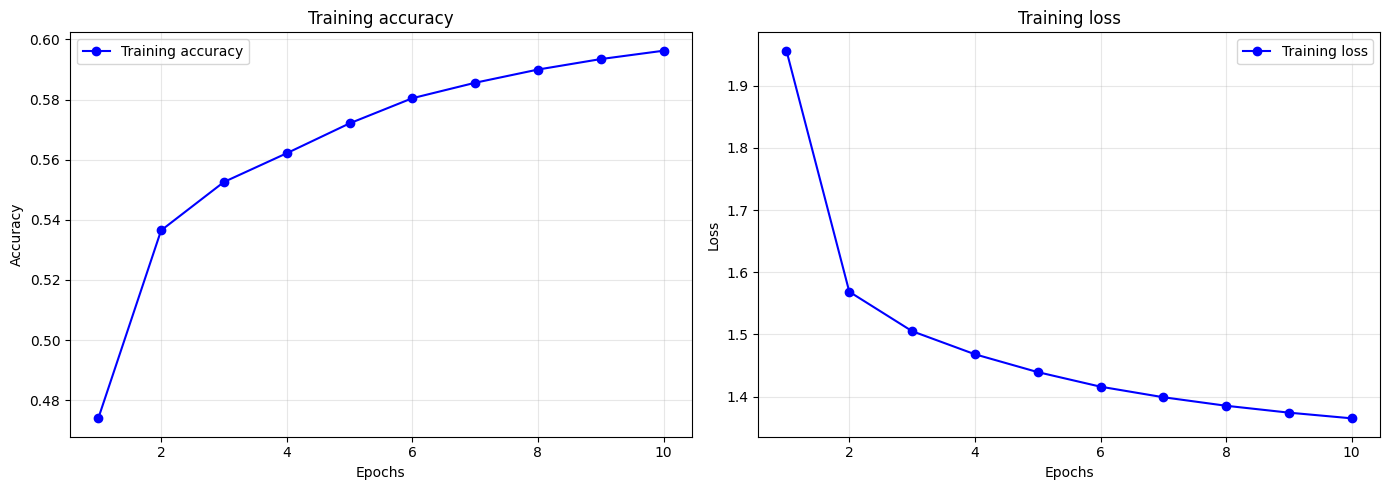

In [30]:
plot(history_transformer)

Vemos que el transformer evoluciona de forma clara y estable durante el entrenamiento. En los primeros epochs el modelo aprende muy rápido: el accuracy pasa de 0.41 en el primer epoch a 0.53 en el segundo, mientras que el loss cae de 2.52 a 1.59. Este salto es menos pronunciado que en los modelos anteriores.

En los epochs intermedios la mejora continúa de forma progresiva hasta alcanzar un accuracy final de 0.5956 (muy similar al 0.6041 de la RNN anidada).

En general, el comportamiento durante el entrenamiento es el mismo en todos los modelos que hemos implementado, observando una mejora progresiva del rendimiento a lo largo de los epochs en los 3 casos.

In [31]:
print("EVALUACIÓN EN CONJUNTO DE TEST")
test_loss_transformer, test_accuracy_transformer = transformer.evaluate(X_test, y_test, batch_size=BATCH_SIZE_TRANSFORMER, verbose=1)

print(f"\nResultados Transformer en TEST:")
print(f"\tLoss: {test_loss_transformer:.4f}")
print(f"\tAccuracy: {test_accuracy_transformer:.4f} ({test_accuracy_transformer*100:.2f}%)")

EVALUACIÓN EN CONJUNTO DE TEST
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.5792 - loss: 1.4419

Resultados Transformer en TEST:
	Loss: 1.3885
	Accuracy: 0.5903 (59.03%)


Ahora probamos el modelo Transformer sobre el conjunto de test para analizar su capacidad de generalización sobre datos no vistos durante el entrenamiento.

Aquí, se obtiene una accuracy del 0.5903 y un valor de loss de 1.3885. Estas métricas son muy cercanas a los obtenidas en el entrenamiento. Esta brecha es mínima, mucho menor que en el caso anterior, lo que nos indica que el modelo generaliza muy bien.

Comparado con las RNN anidada, el Transformer obtiene mejores resultados en el conjunto de test, lo que confirma su mayor capacidad para modelar dependencias temporales largas y relaciones complejas entre tokens. Estos resultados muestran que el Transformer es la arquitectura que obtiene el mejor rendimiento entre las tres probadas para la generación musical en este problema.

## 5. Generar nuevos ficheros MIDI

En este apartado usamos los modelos entrenados para generar nuevas secuencias musicales en forma de ficheros MIDI.


Esta función se encarga de generar una secuencia de tokens a partir de un modelo entrenado. Está basada en gran medida la forma de generar nuevos tokens que aparece en el laboratorio 12.

En nuestro caso, la generación puede realizarse o bien desde cero, comenzando con un token inicial (BOS o Bar, ambos estaban en el vocabulario), o bien a partir de una secuencia inicial de tokens, utilizada como contexto.

En cada paso, el modelo predice la distribución de probabilidad del siguiente token y se selecciona uno de ellos, que se añade a la secuencia generada.

- Para realizar cada predicción, se utilizan los últimos `seq_len` tokens como contexto, manteniendo así el mismo tamaño de entrada que durante el entrenamiento. Si el número de tokens disponibles fuera menor que `seq_len`, se rellenan las posiciones iniciales con tokens PAD. Esto permite reutilizar el modelo sin modificar su arquitectura.

- A partir de las salidas del modelo, se obtiene la predicción correspondiente al último token de la secuencia. Los logits se convierten en probabilidades y se muestrea el siguiente token, que se añade al contexto para continuar la generación de forma iterativa.

In [32]:
def generar_tokens_midi(modelo, tokenizer, max_new_tokens=50, tokens_iniciales=None, seq_len=50):
    """
    Parámetros:
    - modelo: modelo entrenado que vamos a usar para predecir
    - tokenizer: tokenizador
    - max_new_tokens: número total de tokens a generar
    - tokens_iniciales: lista de tokens para comenzar (None = desde cero)
    - seq_len: longitud de la ventana (50 en nuestro caso)

    Devuelve:
    - Lista con todos los tokens generados
    """

    # Inicializar contexto
    if tokens_iniciales is None:
        # Desde cero: empezar con token BOS o Bar
        if 'BOS_None' in tokenizer.vocab:
            context = np.array([tokenizer['BOS_None']]).reshape((1, 1))
        else:
            context = np.array([tokenizer['Bar_None']]).reshape((1, 1))
        print(f"Generando desde cero (token inicial: {context[0, 0]})")
    else:
        # Si hay tokens iniciales usarlos
        context = np.array(tokens_iniciales).reshape((1, -1))
        print(f"Usando {len(tokens_iniciales)} tokens iniciales")

    print(f"Objetivo: generar {max_new_tokens} tokens en total")

    # Generar tokens uno a uno (como en el laboratorio)
    while context.shape[1] < max_new_tokens:
        # Tomar los últimos seq_len tokens como contexto (como en el laboratorio)
        idx_cond = context[:, -seq_len:]

        # Si hay menos de seq_len tokens, rellenar con pad
        if idx_cond.shape[1] < seq_len:
            pad_token = tokenizer['PAD_None']
            padding_needed = seq_len - idx_cond.shape[1]
            padding = np.full((1, padding_needed), pad_token)
            idx_cond = np.concatenate([padding, idx_cond], axis=1)

        # Predecir siguiente token
        # logits shape: (1, seq_len, vocab_size)
        logits = modelo(idx_cond, training=False)

        # Tomar solo la predicción del último token
        logits_last = logits[0, -1].numpy().astype(np.float64)

        # Convertir a probabilidades
        logits_last = np.exp(logits_last - logits_last.max())
        probs = logits_last / logits_last.sum()

        # Muestrear siguiente token (como en el laboratorio)
        new_token = np.argmax(np.random.multinomial(1, probs))

        # Añadir a la secuencia
        context = np.append(context, new_token).reshape((1, -1))

        # Mostrar progreso
        if context.shape[1] % 50 == 0:
            print(f"  Generados {context.shape[1]} tokens...")

    print(f"Completado: generados {context.shape[1]} tokens")

    # Devolver solo los tokens generados (sin el batch dimension)
    return context[0].tolist()

Una vez generada la secuencia de tokens, esta se convierte de nuevo a un fichero MIDI utilizando el tokenizador.

In [33]:
# FUNCIÓN PARA CONVERTIR TOKENS A MIDI
def tokens_a_midi(tokens, tokenizer, nombre_archivo):
    # Crear TokSequence
    tok_sequence = TokSequence(ids=tokens)
    # Convertir a MIDI
    midi = tokenizer.decode([tok_sequence])
    # Guardar
    midi.dump_midi(nombre_archivo)
    print(f"Guardado: {nombre_archivo}")

En esta función se generan todos los ficheros MIDI que se piden para un modelo.

Para cada modelo se generan:
- Secuencias desde cero.
- Secuencias condicionadas a los primeros 30 tokens de un fichero del conjunto de test.
- Para cada caso, dos longitudes distintas: 50 y 200 tokens.

Estos ficheros se almacenan en una misma carpeta. Almacenamos en carpetas distintas los archivos generados por cada modelo.

In [34]:
# GENERAR TODOS LOS ARCHIVOS REQUERIDOS
def generar_midis_completo(modelo, tokenizer, test_files, nombre_red, carpeta_salida='midis_generados'):

    os.makedirs(carpeta_salida, exist_ok=True) # Crear carpeta de salida si no existe

    print(f"GENERACIÓN DE ARCHIVOS MIDI para {nombre_red}")

    print("\nGeneración DESDE CERO - 50 tokens\n")

    tokens_1 = generar_tokens_midi(modelo=modelo, tokenizer=tokenizer,
        max_new_tokens=50, tokens_iniciales=None)
    tokens_a_midi(tokens=tokens_1, tokenizer=tokenizer,
        nombre_archivo=f"{carpeta_salida}/desde_cero_50_tokens.mid")

    print("\nGeneración DESDE CERO - 200 tokens\n")

    tokens_2 = generar_tokens_midi(modelo=modelo, tokenizer=tokenizer,
        max_new_tokens=200, tokens_iniciales=None)
    tokens_a_midi(tokens=tokens_2, tokenizer=tokenizer,
        nombre_archivo=f"{carpeta_salida}/desde_cero_200_tokens.mid")

    print("\nGeneración con TOKENS INICIALES - 50 tokens en total\n")

    # Obtener primeros 30 tokens del primer archivo de test
    primer_test = test_files[0]
    print(f"Archivo de test utilizado: {os.path.basename(primer_test)}")

    tokens_test = tokenizer(primer_test)
    tokens_iniciales = tokens_test[0].ids[:30]

    tokens_3 = generar_tokens_midi(modelo=modelo, tokenizer=tokenizer,
        max_new_tokens=50, tokens_iniciales=tokens_iniciales)
    tokens_a_midi(tokens=tokens_3, tokenizer=tokenizer,
        nombre_archivo=f"{carpeta_salida}/con_30_iniciales_50_tokens.mid")

    print("\n Generación con TOKENS INICIALES - 200 tokens en total\n")

    tokens_4 = generar_tokens_midi(modelo=modelo, tokenizer=tokenizer,
        max_new_tokens=200, tokens_iniciales=tokens_iniciales)
    tokens_a_midi(tokens=tokens_4, tokenizer=tokenizer,
        nombre_archivo=f"{carpeta_salida}/con_30_iniciales_200_tokens.mid")

    print("GENERACIÓN COMPLETADA")
    print(f"\nArchivos guardados en: {carpeta_salida}/\n")

In [35]:
generar_midis_completo(modelo=model_simple, tokenizer=tokenizer, test_files=test_files, nombre_red = "red simple", carpeta_salida='midis_generados_simple')

generar_midis_completo(modelo=model_anidada, tokenizer=tokenizer, test_files=test_files,  nombre_red = "red anidada", carpeta_salida='midis_generados_anidada')

generar_midis_completo(modelo=transformer, tokenizer=tokenizer, test_files=test_files,  nombre_red = "transformer", carpeta_salida='midis_generados_transformer')

GENERACIÓN DE ARCHIVOS MIDI para red simple

Generación DESDE CERO - 50 tokens

Generando desde cero (token inicial: 1)
Objetivo: generar 50 tokens en total
  Generados 50 tokens...
Completado: generados 50 tokens
Guardado: midis_generados_simple/desde_cero_50_tokens.mid

Generación DESDE CERO - 200 tokens

Generando desde cero (token inicial: 1)
Objetivo: generar 200 tokens en total
  Generados 50 tokens...
  Generados 100 tokens...
  Generados 150 tokens...
  Generados 200 tokens...
Completado: generados 200 tokens
Guardado: midis_generados_simple/desde_cero_200_tokens.mid

Generación con TOKENS INICIALES - 50 tokens en total

Archivo de test utilizado: 002_1943_TheBattleofMidway_00_01Title.mid
Usando 30 tokens iniciales
Objetivo: generar 50 tokens en total
  Generados 50 tokens...
Completado: generados 50 tokens
Guardado: midis_generados_simple/con_30_iniciales_50_tokens.mid

 Generación con TOKENS INICIALES - 200 tokens en total

Usando 30 tokens iniciales
Objetivo: generar 200 tok